In [1]:
import pyproj
import itertools
import numpy as np
import verde as vd
import harmonica as hm
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from eql_source_layouts import point_per_block

In [2]:
# Fetch magnetic anomaly data from Rio de Janeiro
data = hm.datasets.fetch_rio_magnetic()

# Reduce region of the survey to speed things up
region = [-42.60, -42.40, -22.32, -22.20]
inside = vd.inside((data.longitude.values, data.latitude.values), region)
data = data[inside]

# Project coordinates
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())
data["easting"], data["northing"] = projection(
    data.longitude.values, data.latitude.values
)
coordinates = (data["easting"], data["northing"], data.altitude_m)

In [3]:
region = vd.get_region(coordinates)
print(region[1] - region[0])
print(region[3] - region[2])

20570.150340475142
13272.267599406186


## Model selection

In [14]:
# Build combination of parameters
spacings = [400, 500, 800]
upwards = np.linspace(-1e3, 0, 11)

# Use itertools to create a list with all combinations of parameters to test
parameter_sets = [
    dict(spacing=combo[0], upward=combo[1])
    for combo in itertools.product(spacings, upwards)
]
print("Number of combinations:", len(parameter_sets))

Number of combinations: 33


In [15]:
scores = []
gridder = hm.EQLHarmonic()

for params in parameter_sets:
    points = point_per_block(coordinates, **params)
    gridder.set_params(points=points)
    shuffle = ShuffleSplit(n_splits=10, test_size=0.3, random_state=1)
    score = np.mean(
        vd.cross_val_score(
            gridder, coordinates, data.total_field_anomaly_nt, cv=shuffle
        )
    )
    scores.append(score)
print("Scores: {}".format(scores))

Scores: [-138.11120825098374, -71.6825433051203, -30.359246851258252, -10.466536534692839, -3.3237239935740783, -2.120919686615308, -2.680597889615435, -3.340457233430464, -25.761432786942812, -90.89933717415671, -65.06479388092065, 0.972927768398617, 0.972239019996659, 0.9724735325528737, 0.9731068438055652, 0.9745476559608441, 0.9752815954050578, 0.97410315356344, 0.9696447410667112, 0.9641801130733608, 0.9605142107513535, 0.9421587884926801, 0.9210415373331878, 0.9214806008830771, 0.9221289078732775, 0.9228713085594251, 0.923530300956765, 0.9239368200166282, 0.9240985838444467, 0.9241283891448424, 0.9235688614597551, 0.9209264108705915, 0.9124327053699135]


In [16]:
best = np.argmax(scores)
print("Best score:", scores[best])
print("Best parameters:", parameter_sets[best])

params = parameter_sets[best]
points = point_per_block(coordinates, **params)
gridder.set_params(points=points)

Best score: 0.9752815954050578
Best parameters: {'spacing': 500, 'upward': -500.0}


EQLHarmonic(damping=None, depth_factor=3, k_nearest=1,
            points=(array([-4390589.71685448, -4390088.00587056, -4389586.29488665, ...,
       -4371524.69946575, -4371022.98848183, -4370521.27749792]),
                    array([-2345796.16660145, -2345796.16660145, -2345796.16660145, ...,
       -2333015.46446869, -2333015.46446869, -2333015.46446869]),
                    array([-500., -500., -500., ..., -500., -500., -500.])))

## Predict values on a regular grid

In [17]:
# Interpolate data into the regular grid at 200m above the sea level
region = vd.get_region(coordinates)
grid = gridder.grid(
    region=region, spacing=50, data_names=["magnetic_anomaly"], extra_coords=200
)

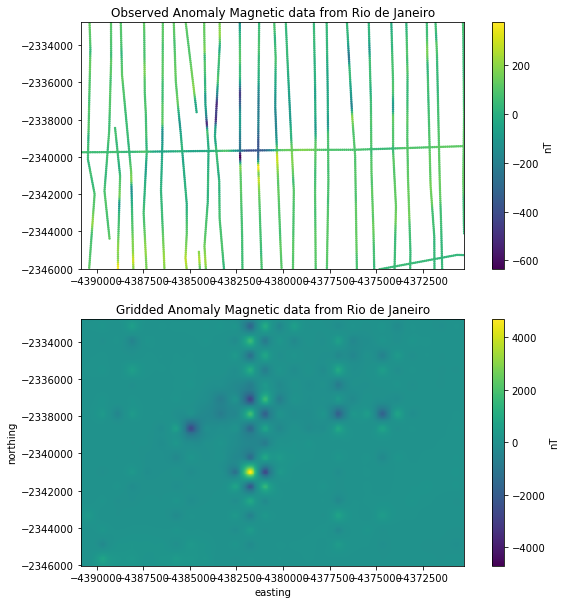

In [18]:
# Plot original magnetic anomaly
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
tmp = ax1.scatter(data.easting, data.northing, c=data.total_field_anomaly_nt, s=2)
plt.colorbar(tmp, ax=ax1, label="nT")
ax1.set_xlim(*region[:2])
ax1.set_ylim(*region[2:])
ax1.set_aspect("equal")
ax1.set_title("Observed Anomaly Magnetic data from Rio de Janeiro")

# Plot gridded magnetic anomaly
tmp = grid.magnetic_anomaly.plot.pcolormesh(ax=ax2, add_colorbar=False, cmap="viridis")
plt.colorbar(tmp, ax=ax2, label="nT")
ax2.set_xlim(*region[:2])
ax2.set_ylim(*region[2:])
ax2.set_aspect("equal")
ax2.set_title("Gridded Anomaly Magnetic data from Rio de Janeiro")
plt.show()